# Reuters 新闻多分类

将新闻划分为 46 个互斥的主题，这是一个 **<font color='red'>mulitclass classification</font>** 问题，每个 sample 只能划分到一个类别，也可以说是一个 **<font color='red'>single-label, mulitclass classification</font>** 问题。

如果一条新闻被划分到多个主题（类别），那就是一个 **<font color='red'>multilabel, multiclass classification</font>** 问题。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
tf.__version__

'2.1.0'

In [3]:
# Load the data
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.reuters.load_data(
    # Words are ranked by how often they occur (in the training set)
    # and only the most frequent words are kept.
    num_words=10000)  # Max number of words to include.

In [4]:
train_data.shape, test_data.shape

((8982,), (2246,))

In [5]:
print(train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [6]:
word_index = tf.keras.datasets.reuters.get_word_index()
index_word = dict([(value, key) for key, value in word_index.items()])
# 减去 3 是因为 0, 1, 2 分别是为 padding, start of sequence, unknown 保留的 index
' '.join([index_word.get(i-3, '?') for i in train_data[0]])

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [7]:
np.unique(train_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [8]:
train_labels

array([ 3,  4,  3, ..., 25,  3, 25])

In [9]:
def vectorize_sequence(sequences, dimension=10000):
    result = np.zeros(shape=(len(sequences), dimension))
    for i, seq in enumerate(sequences):
        result[i, seq] = 1.
    return result


x_train = vectorize_sequence(train_data)  # 训练数据向量化
x_test = vectorize_sequence(test_data)  # 测试数据向量化

**<font color='crimson'>标签向量化有 2 种方法：</font>**

1. 将标签列表转换为整数张量

2. 使用 one-hot 编码

**<font color='blue'>标签向量化——one-hot</font>**

In [10]:
# one-hot 编码标签向量
one_hot_train_labels = tf.keras.utils.to_categorical(train_labels)
one_hot_test_labels = tf.keras.utils.to_categorical(test_labels)

one_hot_train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

<div class="alert alert-block alert-info">

<b>对于 Dense 层的堆叠，每层只能访问上一层输出的信息。如果每一层丢失了与任务（这里是分类问题）相关的一些信息，那么这些信息无法被后面的层找回，也就是说，每一层都可能成为信息瓶颈。</b>

<b>较少维度的层可能会成为信息瓶颈，永久地丢失信息。</b>

</div>

In [11]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(10000, )),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(46, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


- NN 的最后一层 unit 等于 46。这意味着，对于每个输入 sample，NN 都会输出一个 46 维向量。这个向量的每个元素（每个维度）代表不同的输出类别。


- NN 最后一层使用了 `activation='softmax'`。NN 将输出在 46 个不同输出类别上的**概率分布**——对于每一个输入 sample，NN 都会输出一个 46 维向量，其中 `output[i]` 是 sample 属于第 i 个类别的概率。46 个概率之和等于 1。

这里，最好的损失函数是 categorical_crossentropy (分类交叉熵)。它用于衡量两个概率分布之间的距离，这里两个概率分布分别是 NN 输出的概率分布和真实标签的分布。通过将两个分布的距离最小化，训练 NN 可使输出结果尽可能接近真实标签。

In [12]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [13]:
x_val = x_train[:1000]
x_train_partial = x_train[1000:]

y_val = one_hot_train_labels[:1000]
y_train_partial = one_hot_train_labels[1000:]

In [14]:
history = model.fit(x_train_partial,
                    y_train_partial,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 117us/sample - loss: 2.6639 - acc: 0.5500 - val_loss: 1.7440 - val_acc: 0.6560
Epoch 2/20
7982/7982 [==============================] - 0s 60us/sample - loss: 1.4056 - acc: 0.7111 - val_loss: 1.3053 - val_acc: 0.7100
Epoch 3/20
7982/7982 [==============================] - 0s 59us/sample - loss: 1.0433 - acc: 0.7762 - val_loss: 1.1426 - val_acc: 0.7480
Epoch 4/20
7982/7982 [==============================] - 0s 61us/sample - loss: 0.8306 - acc: 0.8225 - val_loss: 1.0451 - val_acc: 0.7760
Epoch 5/20
7982/7982 [==============================] - 0s 59us/sample - loss: 0.6646 - acc: 0.8616 - val_loss: 0.9732 - val_acc: 0.7920
Epoch 6/20
7982/7982 [==============================] - 0s 60us/sample - loss: 0.5332 - acc: 0.8890 - val_loss: 0.9425 - val_acc: 0.8080
Epoch 7/20
7982/7982 [==============================] - 0s 59us/sample - loss: 0.4308 - acc: 0.9074 - val_loss: 0.9322 - val_acc:

In [15]:
def plot_history(history):
    history_dict = history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    epochs = [i + 1 for i in history.epoch]

    # Plot the results
    plt.figure(figsize=(12, 3.8))
    plt.subplot(121)
    plt.plot(epochs, loss_values, 'b-', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b.-', label='Val loss')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=14)
    plt.title('Training and validation loss', fontsize=16)

    plt.subplot(122)
    plt.plot(epochs, acc, 'b-', label='Training acc')
    plt.plot(epochs, val_acc, 'b.-', label='Val acc')
    plt.xlabel('Epochs', fontsize=12)
    plt.xticks(epochs)
    plt.ylabel('Acc', fontsize=12)
    plt.legend(fontsize=14)
    plt.title('Training and validation acc', fontsize=16)

    plt.show()

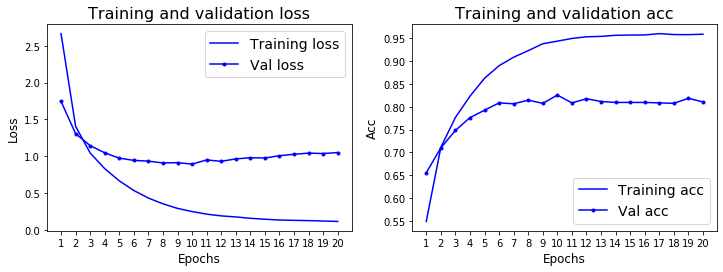

In [16]:
plot_history(history)

In [17]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(10000, )),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(46, activation='softmax')
])

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(x_train_partial,
                    y_train_partial,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/10
7982/7982 [==============================] - 1s 109us/sample - loss: 2.6296 - acc: 0.5152 - val_loss: 1.7666 - val_acc: 0.6420
Epoch 2/10
7982/7982 [==============================] - 0s 60us/sample - loss: 1.4543 - acc: 0.6993 - val_loss: 1.3443 - val_acc: 0.7080
Epoch 3/10
7982/7982 [==============================] - 0s 58us/sample - loss: 1.0901 - acc: 0.7590 - val_loss: 1.1852 - val_acc: 0.7360
Epoch 4/10
7982/7982 [==============================] - 0s 58us/sample - loss: 0.8647 - acc: 0.8067 - val_loss: 1.0512 - val_acc: 0.7700
Epoch 5/10
7982/7982 [==============================] - 0s 58us/sample - loss: 0.6879 - acc: 0.8507 - val_loss: 0.9809 - val_acc: 0.7860
Epoch 6/10
7982/7982 [==============================] - 0s 60us/sample - loss: 0.5500 - acc: 0.8849 - val_loss: 0.9449 - val_acc: 0.8010
Epoch 7/10
7982/7982 [==============================] - 0s 59us/sample - loss: 0.4412 - acc: 0.9085 - val_loss: 0.9317 - val_acc:

In [18]:
model.evaluate(x_test, one_hot_test_labels)

2246/2246 [==============================] - 0s 64us/sample - loss: 0.9854 - acc: 0.7925


[0.9853821959966862, 0.79252005]

In [19]:
model.predict(x_test)  # 每个 sample 返回 46 个主题的概率

array([[4.44875477e-05, 1.85873374e-04, 6.20270248e-06, ...,
        8.25476582e-06, 2.10961971e-05, 1.82922322e-05],
       [6.90973684e-05, 3.17298993e-02, 3.29482311e-04, ...,
        1.40733377e-04, 2.63011543e-06, 1.14206330e-06],
       [1.32739721e-02, 7.74432003e-01, 2.80826865e-03, ...,
        2.03787023e-03, 2.02137977e-04, 1.16374751e-03],
       ...,
       [9.87706972e-06, 9.35939388e-05, 1.21390085e-05, ...,
        5.43538590e-06, 1.44443011e-05, 3.85730527e-05],
       [1.86800933e-03, 5.47020882e-02, 3.58297955e-03, ...,
        6.30377093e-04, 5.19052555e-04, 1.28232955e-03],
       [1.12106546e-03, 5.19490719e-01, 7.18290824e-03, ...,
        6.07172085e-04, 2.18282275e-05, 6.05964524e-05]], dtype=float32)

In [20]:
# Random classification
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)

hist_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hist_array)) / len(test_labels)

0.18432769367764915

**<font color='blue'>标签向量化——转换为整数张量</font>**

In [21]:
train_labels

array([ 3,  4,  3, ..., 25,  3, 25])

In [22]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

y_train

array([ 3,  4,  3, ..., 25,  3, 25])

**唯一需要修改的是损失函数。整数标签应该使用 `sparse_categorical_crossentropy`，不是 `categorical_crossentropy`。**

In [23]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(10000, )),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(46, activation='softmax')
])

model.compile(
    optimizer='rmsprop',
    loss='sparse_categorical_crossentropy',  # Notice here!
    metrics=['acc'])

history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=512,
                    validation_data=(x_test, y_test))

Train on 8982 samples, validate on 2246 samples
Epoch 1/10
8982/8982 [==============================] - 1s 105us/sample - loss: 2.4703 - acc: 0.5183 - val_loss: 1.6553 - val_acc: 0.6643
Epoch 2/10
8982/8982 [==============================] - 1s 62us/sample - loss: 1.3285 - acc: 0.7240 - val_loss: 1.2805 - val_acc: 0.7195
Epoch 3/10
8982/8982 [==============================] - 1s 64us/sample - loss: 0.9748 - acc: 0.7935 - val_loss: 1.1258 - val_acc: 0.7471
Epoch 4/10
8982/8982 [==============================] - 1s 63us/sample - loss: 0.7617 - acc: 0.8410 - val_loss: 1.0331 - val_acc: 0.7716
Epoch 5/10
8982/8982 [==============================] - 1s 64us/sample - loss: 0.6042 - acc: 0.8792 - val_loss: 0.9778 - val_acc: 0.7867
Epoch 6/10
8982/8982 [==============================] - 1s 63us/sample - loss: 0.4829 - acc: 0.9017 - val_loss: 0.9356 - val_acc: 0.7939
Epoch 7/10
8982/8982 [==============================] - 1s 62us/sample - loss: 0.3924 - acc: 0.9167 - val_loss: 0.9471 - val_acc:

**<font color='crimson'>Summary:</font>**

- 如果要对 N 个类别进行分类，NN 最后一层应该使用 `Dense(N, activation='softmax')`，这样可以输出在 N 个类别上的概率分布。


- multiclass clf 的损失函数几乎总是分类交叉熵。


- multiclass clf 问题的标签处理方法：

  - 对标签进行 one-hot 编码，然后使用 `loss='categorical_crossentropy'`；
  
  - 将标签编码为整数，然后使用 `loss='sparse_categorical_crossentropy'`。


- 如果需要将数据划分到 N 个类别中，应该避免使用维度较少的中间层，以免在 NN 中造成信息瓶颈。